In [1]:
!pip install tensorflow 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import scipy
from collections import Counter



In [3]:
df = pd.read_csv("/Volumes/Crucial X6/A3/IML a3/code/preprocessing/my_data.csv")
df.head()

,art_style,painting,emotion,utterance,repetition,caption_length,tokens
0,Impressionism,gregoire-boonzaier_self-portrait-1969,sadness,The man has a lot of wrinkles on his aging face,6,11,"['the', 'man', 'has', 'a', 'lot', 'of', 'wrink..."
1,Impressionism,john-henry-twachtman_view-along-a-river,awe,The water reflects everything like a portal to...,6,11,"['the', 'water', 'reflects', 'everything', 'li..."
2,Impressionism,john-singer-sargent_palazzo-corner-della-ca-gr...,awe,The beauty of the building puts me into amazem...,6,15,"['the', 'beauty', 'of', 'the', 'building', 'pu..."
3,Romanticism,orest-kiprensky_the-family-of-satyrs,excitement,The imps playfully dance and sing to the music.,6,9,"['the', 'imps', 'playfully', 'dance', 'and', '..."
4,Impressionism,nicolae-grigorescu_clearing-back,awe,The person has a long journey ahead of them th...,6,12,"['the', 'person', 'has', 'a', 'long', 'journey..."


# Preprocessing tests to make it read for training

In [4]:
import ast

df["tokens"] = df["tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [5]:
def enrich_tokens(row):
    # Emotion tag
    emo = row["emotion"]
    if isinstance(emo, str):
        emo = emo.lower().strip().replace(" ", "_")
    else:
        emo = "none"
    emo_tag = f"<emotion_{emo}>"

    # Style tag
    style = row["art_style"]
    if isinstance(style, str):
        style = style.lower().strip().replace(" ", "_")
    else:
        style = "none"
    style_tag = f"<style_{style}>"

    # Caption tokens
    tokens = row["tokens"]
    if not isinstance(tokens, list):
        tokens = []

    # RETURN TAGS + ORIGINAL TOKENS
    return [emo_tag, style_tag] + tokens


df["enriched_tokens"] = df.apply(enrich_tokens, axis=1)
df.head()



,art_style,painting,emotion,utterance,repetition,caption_length,tokens,enriched_tokens
0,Impressionism,gregoire-boonzaier_self-portrait-1969,sadness,The man has a lot of wrinkles on his aging face,6,11,"[the, man, has, a, lot, of, wrinkles, on, his,...","[<emotion_sadness>, <style_impressionism>, the..."
1,Impressionism,john-henry-twachtman_view-along-a-river,awe,The water reflects everything like a portal to...,6,11,"[the, water, reflects, everything, like, a, po...","[<emotion_awe>, <style_impressionism>, the, wa..."
2,Impressionism,john-singer-sargent_palazzo-corner-della-ca-gr...,awe,The beauty of the building puts me into amazem...,6,15,"[the, beauty, of, the, building, puts, me, int...","[<emotion_awe>, <style_impressionism>, the, be..."
3,Romanticism,orest-kiprensky_the-family-of-satyrs,excitement,The imps playfully dance and sing to the music.,6,9,"[the, imps, playfully, dance, and, sing, to, t...","[<emotion_excitement>, <style_romanticism>, th..."
4,Impressionism,nicolae-grigorescu_clearing-back,awe,The person has a long journey ahead of them th...,6,12,"[the, person, has, a, long, journey, ahead, of...","[<emotion_awe>, <style_impressionism>, the, pe..."


## Lets build the vocab


In [6]:
from collections import Counter

all_tokens = [w for seq in df["enriched_tokens"] for w in seq]
freq = Counter(all_tokens)

vocab_size = 8000  # Adjust if you want
most_common = freq.most_common(vocab_size - 4)

itos = ["<pad>", "<unk>", "<start>", "<end>"] + [w for w,_ in most_common]
stoi = {w: i for i, w in enumerate(itos)}

print("Vocabulary size:", len(itos))


Vocabulary size: 8000


In [7]:
# Add <start> and <end> tokens to each sequence
def add_special_tokens(tokens):
    return ["<start>"] + tokens + ["<end>"]

df["enriched_tokens_with_special"] = df["enriched_tokens"].apply(add_special_tokens)
df.head()

,art_style,painting,emotion,utterance,repetition,caption_length,tokens,enriched_tokens,enriched_tokens_with_special
0,Impressionism,gregoire-boonzaier_self-portrait-1969,sadness,The man has a lot of wrinkles on his aging face,6,11,"[the, man, has, a, lot, of, wrinkles, on, his,...","[<emotion_sadness>, <style_impressionism>, the...","[<start>, <emotion_sadness>, <style_impression..."
1,Impressionism,john-henry-twachtman_view-along-a-river,awe,The water reflects everything like a portal to...,6,11,"[the, water, reflects, everything, like, a, po...","[<emotion_awe>, <style_impressionism>, the, wa...","[<start>, <emotion_awe>, <style_impressionism>..."
2,Impressionism,john-singer-sargent_palazzo-corner-della-ca-gr...,awe,The beauty of the building puts me into amazem...,6,15,"[the, beauty, of, the, building, puts, me, int...","[<emotion_awe>, <style_impressionism>, the, be...","[<start>, <emotion_awe>, <style_impressionism>..."
3,Romanticism,orest-kiprensky_the-family-of-satyrs,excitement,The imps playfully dance and sing to the music.,6,9,"[the, imps, playfully, dance, and, sing, to, t...","[<emotion_excitement>, <style_romanticism>, th...","[<start>, <emotion_excitement>, <style_romanti..."
4,Impressionism,nicolae-grigorescu_clearing-back,awe,The person has a long journey ahead of them th...,6,12,"[the, person, has, a, long, journey, ahead, of...","[<emotion_awe>, <style_impressionism>, the, pe...","[<start>, <emotion_awe>, <style_impressionism>..."


In [8]:
def tokens_to_ids(seq):
    return [stoi.get(w, stoi["<unk>"]) for w in seq]

# Use the version WITH special tokens
df["token_ids"] = df["enriched_tokens_with_special"].apply(tokens_to_ids)

In [9]:
lengths = np.array(list(map(len, df["token_ids"])))
max_len = int(np.quantile(lengths, 0.95))
print("Max sequence length:", max_len)


Max sequence length: 33


In [10]:
pad_id = stoi["<pad>"]

def pad_to_max(seq, max_len=max_len):
    seq = seq[:max_len]                      
    return seq + [pad_id] * (max_len - len(seq))

df["padded"] = df["token_ids"].apply(pad_to_max)


In [11]:
import json

df.to_pickle("preprocessed_dataset.pkl")

with open("itos.json", "w") as f:
    json.dump(itos, f)

with open("stoi.json", "w") as f:
    json.dump(stoi, f)

# Save config with special token IDs
with open("config.json", "w") as f:
    json.dump({
        "max_len": max_len,
        "pad_id": stoi["<pad>"],
        "start_id": stoi["<start>"],
        "end_id": stoi["<end>"],
        "unk_id": stoi["<unk>"]
    }, f)

## TFIDF represenation generation


In [12]:
!pip install umap-learn

/Users/manasvenkatasairavulapalli/mambaforge3/envs/work/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


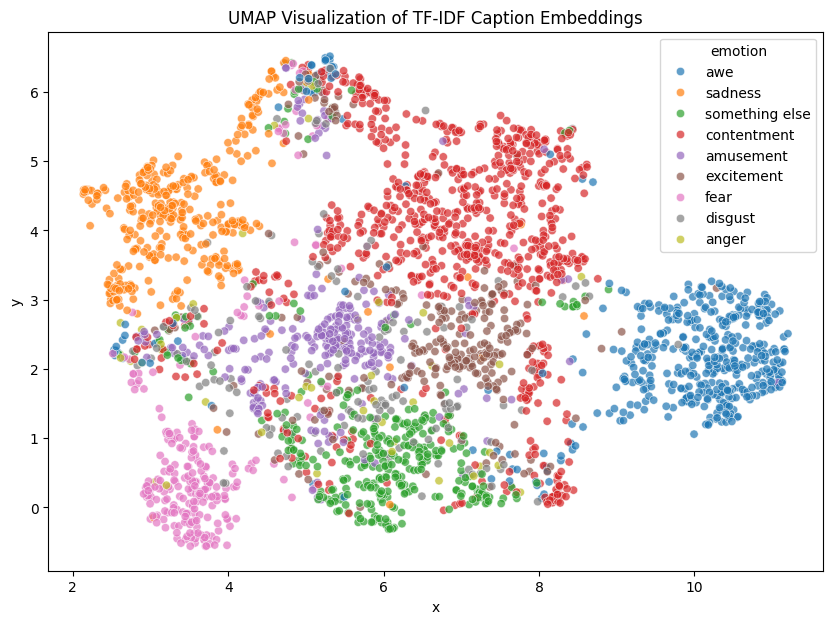

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap
import numpy as np

# Subsample for speed
df_sample = df.sample(3000, random_state=42)

# 1. Join tokens
df_sample["joined"] = df_sample["enriched_tokens"].apply(lambda x: " ".join(x))

# 2. TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_sample["joined"])

# 3. PCA to 20 dims
X_20 = PCA(n_components=20).fit_transform(X.toarray())

# 4. UMAP 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
X_2D = reducer.fit_transform(X_20)

# 5. Plot colored by emotion
df_plot = df_sample.reset_index(drop=True)
df_plot["x"] = X_2D[:,0]
df_plot["y"] = X_2D[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df_plot,
    x="x", y="y",
    hue="emotion",
    alpha=0.7,
    palette="tab10"
)
plt.title("UMAP Visualization of TF-IDF Caption Embeddings")
plt.show()


In [14]:
import pickle

# 1. Join tokens for full dataset
df["joined"] = df["enriched_tokens"].apply(lambda x: " ".join(x))

# 2. Fit TF-IDF on *full data*, not the 3k sample
vectorizer = TfidfVectorizer(max_features=5000)
X_full = vectorizer.fit_transform(df["joined"])

# 3. PCA for dimension reduction (20–300 dimensions)
pca = PCA(n_components=300)   # 300 recommended for LSTM input
X_full_pca = pca.fit_transform(X_full.toarray())

# 4. Store PCA vectors inside dataframe
df["tfidf_vec"] = list(X_full_pca)

# 5. Save dataframe with TF-IDF embeddings
df.to_pickle("preprocessed_dataset_with_tfidf.pkl")
print("Saved: preprocessed_dataset_with_tfidf.pkl")

# 6. Save models separately for reproducibility
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("tfidf_pca.pkl", "wb") as f:
    pickle.dump(pca, f)

print("Saved: tfidf_vectorizer.pkl + tfidf_pca.pkl")


Saved: preprocessed_dataset_with_tfidf.pkl
Saved: tfidf_vectorizer.pkl + tfidf_pca.pkl
Saved: tfidf_vectorizer.pkl + tfidf_pca.pkl
